In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys 
from optimization.optimizers import Optimizer
from optimization.schedulers import *
from optimization.optimization_loops import optimize
from optimization.functions import *
from optimization.utils import *

# LAB1

In [2]:
init_point = np.array([0.0, -4.0])
func_dict = FUNCTIONS['himmelblau']# "himmelblau" or 'eggholder'


optimizer = Optimizer(
    function_grad= func_dict["gradient"],
    method= "sgd", #'nag',#"rmsprop",#'adagrad',#'nag2',#"ema_gd",#"gd",
    learning_rate= 0.042, # don`t use lr>0.001 with sgd and himmelblau
    gamma=0.99
)

sched = ReduceLrOnPlateau(
    optimizer= optimizer,
    wait_epochs=10,
    lr_scale=0.9,
    threshold_percentage=5)

points = optimize(
    init_point= init_point,
    epochs= 50,
    function= func_dict["function"],
    optimizer=optimizer,
    scheduler= sched
)

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
reducing lr
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
reducing lr
Epoch  23
Epoch  24
Epoch  25
Epoch  26
Epoch  27
Epoch  28
Epoch  29
Epoch  30
Epoch  31
Epoch  32
Epoch  33
reducing lr
Epoch  34
Epoch  35
Epoch  36
Epoch  37
Epoch  38
Epoch  39
Epoch  40
Epoch  41
Epoch  42
Epoch  43
Epoch  44
reducing lr
Epoch  45
Epoch  46
Epoch  47
Epoch  48
Epoch  49


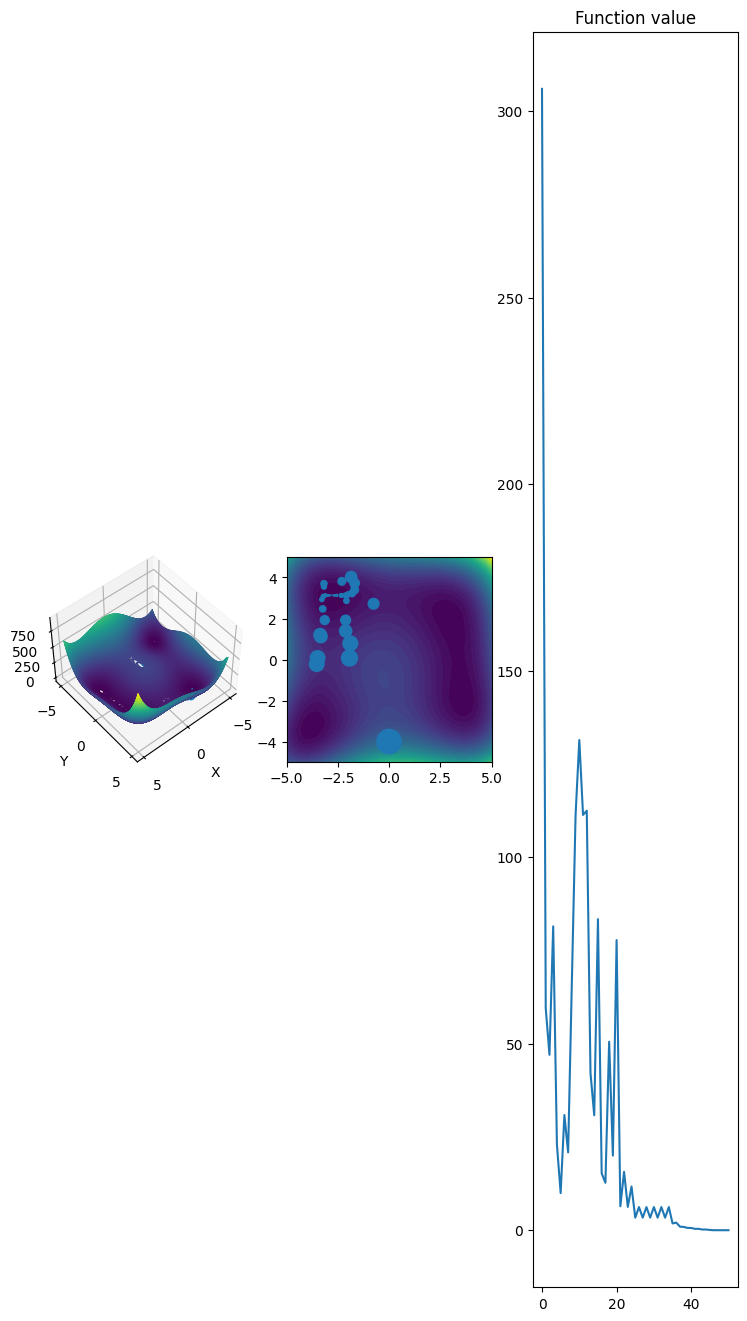

In [3]:
# plot optimization results
plot(
    function= func_dict["function"],
    X=func_dict["X"],
    Y=func_dict["Y"],
    points=points
)

# LAB2-3

## LAB2

### Task1

In [3]:
import pygmo as pg
import time

class Func:
    def __init__(self, function, X, Y):
        self.function=function
        self.bounds=(
            [X.min(), Y.min()], 
            [X.max(), Y.max()]
        )

    def fitness(self, x):
        return [self.function(x)]

    def get_bounds(self):
        return self.bounds

In [4]:
func = Func(
    function= func_dict["function"],
    X=func_dict["X"],
    Y=func_dict["Y"]
)

prob = pg.problem(func)
print(prob)

Problem name: <class '__main__.Func'>
	C++ class name: pybind11::object

	Global dimension:			2
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-5, -5]
	Upper bounds: [5, 5]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [5]:
algo = pg.algorithm(pg.bee_colony(gen = 1000, limit = 30))

pop = pg.population(prob,10)

pop = algo.evolve(pop)

print(pop.champion_f) 

[0.00397156]


In [7]:
pop.champion_x

array([-2.81605985,  3.13016616])

In [21]:
start_time = time.time(); [prob.fitness(init_point) for i in range(10000)]; print(time.time() - start_time)

0.06286215782165527


### Task2

In [ ]:
def MSE(x, desired):
    return (desired -x)**2

In [ ]:
class PID_regulator:

    def __init__(self):

        self.kp = 1
        self.kd = 1
        self.ki = 1
        self.back_conn = 0

        self.integr = 0
        self.deriv = 0
        self.last_val = 0
        self.last_time = 0

    def __call__(self, x):

        diff = x - self.last_val

        proportional = self.kp*diff

        self.integr += self.ki*diff
        self.deriv -= self.kd*diff

        out = proportional+self.deriv+self.integr

        return out


In [ ]:
regulator = PID_regulator()


class Validator:

    def __init__(self, regulator):
        self.regulator = regulator

    def fitness(self, x):
        self.regulator.set_params(x)
        desired_out = 1
        return [self.validate(desired_out)]

    def validate(desired_out):
        difference = regulator(desired_out) - desired_out 
        recalibration_time = 0
        recalibration = difference**2 

        while(difference>0.001):
            recalibration_time +=1 
            difference = regulator(desired_out) - desired_out
            recalibration += difference**2

        print("Recalibration time is", recalibration_time)

        return recalibration  

In [ ]:
class Optimizer:

    def __init__(self, regulator, calibration_algorithm, validator):
        
        self.regulator  = regulator
        self.alg = calibration_algorithm
        self.validator = validator

    def calculate_parameters(self):
        prob = pg.problem(self.validator)
        pop = pg.population(prob,10)
        pop = algo.evolve(pop)
        return pop.champion_x
        
        

    def set_params(self, koefs):
        self.regulator.kp = koefs[0]
        self.regulator.kd = koefs[1]
        self.regulator.ki = koefs[2]



## LAB3

In [27]:
from numba import jit

class Func_speedup:
    def __init__(self, function, X, Y):
        self.function=function
        self.bounds=(
            [X.min(), Y.min()], 
            [X.max(), Y.max()]
        )

    @jit(fastmath=True)
    def fitness(self, x):
        return [self.function(x)]

    def get_bounds(self):
        return self.bounds


func_s = Func_speedup(
    function= func_dict["function"],
    X=func_dict["X"],
    Y=func_dict["Y"])
    
prob_s = pg.problem(func_s)
algo = pg.algorithm(pg.bee_colony(gen = 1000, limit = 30))
pop = pg.population(prob_s,10)
pop = algo.evolve(pop)

start_time = time.time(); [prob_s.fitness(init_point) for i in range(10000)]; print(time.time() - start_time)

/tmp/ipykernel_39732/3650592370.py:11: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fitness" failed type inference due to: non-precise type pyobject
During: typing of argument at /tmp/ipykernel_39732/3650592370.py (13)

File "../../../../tmp/ipykernel_39732/3650592370.py", line 13:
<source missing, REPL/exec in use?>

  @jit(fastmath=True)
/home/led/.local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "fitness" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_39732/3650592370.py", line 11:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/led/.local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readthe

0.3586766719818115


In [35]:
from numba import float64

# Trying to provide strict types using jit  for speedup, doesnt work, maybe because of jupykernel

class Func_speedup:
    def __init__(self, function, X, Y):
        self.function=function
        self.bounds=(
            [X.min(), Y.min()], 
            [X.max(), Y.max()]
        )

    def fitness(self, x):
        return Func_speedup.fitness_(x)

    @jit(
        float64[:](float64[:]),
        forceobj=True
        #nopython=True
        )
    def fitness_(point):
        x, y = point
        return [(x**2+y-11)**2 + (x+y**2-7)**2] # himmelblau function

    def get_bounds(self):
        return self.bounds


func_s = Func_speedup(
    function= func_dict["function"],
    X=func_dict["X"],
    Y=func_dict["Y"])
    
prob_s = pg.problem(func_s)
algo = pg.algorithm(pg.bee_colony(gen = 1000, limit = 30))
pop = pg.population(prob_s,10)
pop = algo.evolve(pop)

start_time = time.time(); [prob_s.fitness(init_point) for i in range(10000)]; print(time.time() - start_time)

0.25443506240844727


# LAB4

In [5]:
import optuna

## Task1

In [36]:
class Metric:

    def __init__(self , function, X, Y):
        
        self.function = function
        self.bounds=(
            [X.min(), Y.min()], 
            [X.max(), Y.max()]
        )
        self.X = X
        self.Y = Y

    def __call__(self, trial):
        
        x = trial.suggest_float("x", self.X.min(), self.X.max())
        y = trial.suggest_float("y", self.Y.min(), self.Y.max())

        return self.function([x, y])

In [38]:
metric = Metric(
    function= func_dict["function"],
    X=func_dict["X"],
    Y=func_dict["Y"])

In [40]:
study = optuna.create_study()
study.optimize(metric, n_trials=100)

[I 2022-11-27 03:55:32,724] A new study created in memory with name: no-name-12c4e965-dc9d-492f-8fbc-abb4e641aa23
[I 2022-11-27 03:55:32,726] Trial 0 finished with value: 72.34963080906435 and parameters: {'x': 4.254208293012606, 'y': 1.3603181788126895}. Best is trial 0 with value: 72.34963080906435.
[I 2022-11-27 03:55:32,728] Trial 1 finished with value: 50.55306441528345 and parameters: {'x': 2.3472198552443757, 'y': 0.10476975934720656}. Best is trial 1 with value: 50.55306441528345.
[I 2022-11-27 03:55:32,731] Trial 2 finished with value: 122.03437663072312 and parameters: {'x': 0.31652004758963415, 'y': 1.1898072315653598}. Best is trial 1 with value: 50.55306441528345.
[I 2022-11-27 03:55:32,733] Trial 3 finished with value: 74.29459098225895 and parameters: {'x': 4.621655336168274, 'y': -1.7749030159590085}. Best is trial 1 with value: 50.55306441528345.
[I 2022-11-27 03:55:32,734] Trial 4 finished with value: 132.2245505491123 and parameters: {'x': -2.3240223871595065, 'y': 4

## Task2

In [3]:
import sklearn

In [6]:
import logging
import sys

import sklearn
import sklearn.datasets
import sklearn.linear_model
import sklearn.model_selection


def objective(trial):
    iris = sklearn.datasets.load_iris()
    classes = list(set(iris.target))
    train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(
        iris.data, iris.target, test_size=0.25, random_state=0
    )

    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    clf = sklearn.linear_model.SGDClassifier(alpha=alpha)

    for step in range(100):
        clf.partial_fit(train_x, train_y, classes=classes)

        # Report intermediate objective value.
        intermediate_value = 1.0 - clf.score(valid_x, valid_y)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()

    return 1.0 - clf.score(valid_x, valid_y)


optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20)

[I 2022-11-27 06:49:57,659] A new study created in memory with name: no-name-5d2183b1-8f4f-4ff8-ae54-0b998fe9d712


A new study created in memory with name: no-name-5d2183b1-8f4f-4ff8-ae54-0b998fe9d712


[I 2022-11-27 06:49:57,907] Trial 0 finished with value: 0.052631578947368474 and parameters: {'alpha': 3.20053224791285e-05}. Best is trial 0 with value: 0.052631578947368474.


Trial 0 finished with value: 0.052631578947368474 and parameters: {'alpha': 3.20053224791285e-05}. Best is trial 0 with value: 0.052631578947368474.


[I 2022-11-27 06:49:58,075] Trial 1 finished with value: 0.02631578947368418 and parameters: {'alpha': 0.002059588011399819}. Best is trial 1 with value: 0.02631578947368418.


Trial 1 finished with value: 0.02631578947368418 and parameters: {'alpha': 0.002059588011399819}. Best is trial 1 with value: 0.02631578947368418.


[I 2022-11-27 06:49:58,264] Trial 2 finished with value: 0.4736842105263158 and parameters: {'alpha': 0.00010547654245277667}. Best is trial 1 with value: 0.02631578947368418.


Trial 2 finished with value: 0.4736842105263158 and parameters: {'alpha': 0.00010547654245277667}. Best is trial 1 with value: 0.02631578947368418.


[I 2022-11-27 06:49:58,443] Trial 3 finished with value: 0.052631578947368474 and parameters: {'alpha': 0.011923202566819332}. Best is trial 1 with value: 0.02631578947368418.


Trial 3 finished with value: 0.052631578947368474 and parameters: {'alpha': 0.011923202566819332}. Best is trial 1 with value: 0.02631578947368418.


[I 2022-11-27 06:49:58,610] Trial 4 finished with value: 0.2894736842105263 and parameters: {'alpha': 0.04548216255364185}. Best is trial 1 with value: 0.02631578947368418.


Trial 4 finished with value: 0.2894736842105263 and parameters: {'alpha': 0.04548216255364185}. Best is trial 1 with value: 0.02631578947368418.


[I 2022-11-27 06:49:58,644] Trial 5 pruned. 


Trial 5 pruned. 


[I 2022-11-27 06:49:58,653] Trial 6 pruned. 


Trial 6 pruned. 


[I 2022-11-27 06:49:58,671] Trial 7 pruned. 


Trial 7 pruned. 


[I 2022-11-27 06:49:58,689] Trial 8 pruned. 


Trial 8 pruned. 


[I 2022-11-27 06:49:58,698] Trial 9 pruned. 


Trial 9 pruned. 


[I 2022-11-27 06:49:58,707] Trial 10 pruned. 


Trial 10 pruned. 


[I 2022-11-27 06:49:58,726] Trial 11 pruned. 


Trial 11 pruned. 


[I 2022-11-27 06:49:58,746] Trial 12 pruned. 


Trial 12 pruned. 


[I 2022-11-27 06:49:58,755] Trial 13 pruned. 


Trial 13 pruned. 


[I 2022-11-27 06:49:58,765] Trial 14 pruned. 


Trial 14 pruned. 


[I 2022-11-27 06:49:58,773] Trial 15 pruned. 


Trial 15 pruned. 


[I 2022-11-27 06:49:58,781] Trial 16 pruned. 


Trial 16 pruned. 


[I 2022-11-27 06:49:58,806] Trial 17 pruned. 


Trial 17 pruned. 


[I 2022-11-27 06:49:58,815] Trial 18 pruned. 


Trial 18 pruned. 


[I 2022-11-27 06:49:58,826] Trial 19 pruned. 


Trial 19 pruned. 
